# Loading images

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchvision import transforms

from torchsummary import summary
%matplotlib inline

In [64]:
%%time
#labels with the same order
train_images = []
train_labels = []

test_images = []
test_dict = {}
train_filenames = []
test_filenames = []


labels_df = pd.read_csv('train_onelabel.csv')
labels_dict = labels_df.set_index('image')['class'].to_dict()

for filename in labels_df['image'].values: ##to keep mapping with classes
    train_images.append(Image.open('train_images/'+filename).copy())
    train_labels.append(labels_dict[filename])
    train_filenames.append(filename)
for filename in glob.iglob('test_images' +'/*'):
    image = Image.open(filename).copy()
    test_images.append(image)
    test_filenames.append(filename.replace('test_images/', ''))

CPU times: user 9.7 s, sys: 1.64 s, total: 11.3 s
Wall time: 18.2 s


In [66]:
test_filenames

['112685.jpg',
 '143252.jpg',
 '35763.jpg',
 '97775.jpg',
 '120683.jpg',
 '46815.jpg',
 '151202.jpg',
 '144821.jpg',
 '147527.jpg',
 '122128.jpg',
 '8099.jpg',
 '45284.jpg',
 '91965.jpg',
 '95941.jpg',
 '66014.jpg',
 '119005.jpg',
 '34655.jpg',
 '90476.jpg',
 '152812.jpg',
 '37310.jpg',
 '149049.jpg',
 '139460.jpg',
 '120979.jpg',
 '158513.jpg',
 '154593.jpg',
 '148620.jpg',
 '34716.jpg',
 '82336.jpg',
 '114679.jpg',
 '19983.jpg',
 '113392.jpg',
 '72020.jpg',
 '139098.jpg',
 '160366.jpg',
 '157161.jpg',
 '5688.jpg',
 '103298.jpg',
 '149822.jpg',
 '60003.jpg',
 '103046.jpg',
 '131641.jpg',
 '80896.jpg',
 '29513.jpg',
 '20063.jpg',
 '35.jpg',
 '7648.jpg',
 '95020.jpg',
 '68687.jpg',
 '101183.jpg',
 '7042.jpg',
 '810.jpg',
 '56049.jpg',
 '42383.jpg',
 '80458.jpg',
 '64688.jpg',
 '30315.jpg',
 '57800.jpg',
 '97893.jpg',
 '107060.jpg',
 '148881.jpg',
 '17870.jpg',
 '141363.jpg',
 '67227.jpg',
 '39523.jpg',
 '69175.jpg',
 '19574.jpg',
 '136532.jpg',
 '17514.jpg',
 '16377.jpg',
 '61849.jpg',


Average width 73.32110394976037 , Average height: 66.46897207073211
CPU times: user 80.8 ms, sys: 3.13 ms, total: 84 ms
Wall time: 112 ms


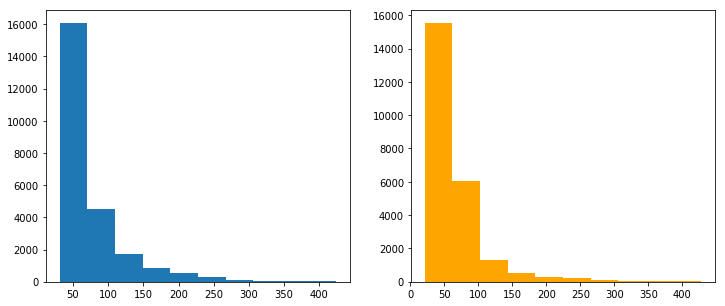

In [3]:
%%time
widths, heights = [], [] 
sumx, sumy = 0, 0
for i in train_images:
    sumx += i.size[0]
    widths.append(i.size[0])
    sumy += i.size[1]
    heights.append(i.size[1])


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(widths)
ax2.hist(heights, color = 'orange')
fig.set_size_inches(12, 5)

avg_width = np.mean(widths)
avg_height = np.mean(heights)
print('Average width {} , Average height: {}'.format(avg_width, avg_height))

In [39]:
class ListsTrainDataset(Dataset):
    def __init__(self, list_of_images, list_of_labels, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
#         super().__init__()
        self.data = list_of_images
        self.labels = np.asarray(list_of_labels).reshape(-1,1)
        self.transform = transform

    def __getitem__(self, index):
        single_image = self.data[index]
        single_image_label = self.labels[index]
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(single_image)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data)

In [65]:
class ListsTestDataset(Dataset):
    def __init__(self, list_of_images, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = list_of_images
        self.transform = transform

    def __getitem__(self, index):
        single_image = self.data[index]
        if self.transform is not None:
            img_as_tensor = self.transform(single_image)
        # Return image ONLY
        return img_as_tensor

    def __len__(self):
        return len(self.data)

In [71]:
#Transforms and Dataset Creation
test_transforms = transforms. Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor()
])
train_transforms = transforms. Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor()
])

train_dataset = ListsTrainDataset(train_images, train_labels, transform = train_transforms)
test_dataset = ListsTestDataset(test_images, transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1000, shuffle = False)

In [10]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(50, 20, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            Flatten(),
            nn.Linear(20*7*7, 250),
            nn.ReLU())
        self.fc = nn.Linear(250, 121)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.fc(out)
        return out

In [11]:
def train(model, num_epochs):
    criterion = nn.CrossEntropyLoss();
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
    #Training
    history = {'batch': [], 'loss': [], 'accuracy': []}
    for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images = Variable(images).cuda()
                labels = Variable(labels).squeeze(1).long().cuda()#.cpu()
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, argmax = torch.max(outputs, 1)
                accuracy_train = (labels == argmax.squeeze()).float().mean()*100
                # Show progress
                if (i+1) % 32 == 0:
                    log = " ".join([
                      "Epoch : %d/%d" % (epoch+1, num_epochs),
                      "Iter : %d/%d" % (i+1, len(train_dataset)//batch_size),
                      "Loss: %.4f" % loss.item(),
                      "Accuracy: %.4f" % accuracy_train])
                    print('\r{}'.format(log), end='')
                    history['batch'].append(i)
                    history['loss'].append(loss.item())
                    history['accuracy'].append(accuracy_train.item())
            print()
    return model

In [13]:
cnn = CNN().cuda()
summary(cnn, (1,28,28))
#Hyperparameters
learning_rate = 0.0005
batch_size = 32

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 50, 28, 28]             500
              ReLU-2           [-1, 50, 28, 28]               0
         MaxPool2d-3           [-1, 50, 14, 14]               0
            Conv2d-4           [-1, 20, 14, 14]           9,020
              ReLU-5           [-1, 20, 14, 14]               0
         MaxPool2d-6             [-1, 20, 7, 7]               0
           Flatten-7                  [-1, 980]               0
            Linear-8                  [-1, 250]         245,250
              ReLU-9                  [-1, 250]               0
           Linear-10                  [-1, 121]          30,371
Total params: 285,141
Trainable params: 285,141
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 1.09
Estimated T

In [14]:
%%time
cnn = train(cnn, num_epochs = 100)

Epoch : 1/100 Iter : 736/756 Loss: 2.7104 Accuracy: 43.7500
Epoch : 2/100 Iter : 736/756 Loss: 2.6950 Accuracy: 31.2500
Epoch : 3/100 Iter : 736/756 Loss: 2.2939 Accuracy: 34.3750
Epoch : 4/100 Iter : 736/756 Loss: 2.1584 Accuracy: 37.5000
Epoch : 5/100 Iter : 736/756 Loss: 2.2248 Accuracy: 53.1250
Epoch : 6/100 Iter : 736/756 Loss: 1.6611 Accuracy: 53.1250
Epoch : 7/100 Iter : 736/756 Loss: 2.1161 Accuracy: 56.2500
Epoch : 8/100 Iter : 736/756 Loss: 2.1618 Accuracy: 37.5000
Epoch : 9/100 Iter : 736/756 Loss: 1.9598 Accuracy: 40.6250
Epoch : 10/100 Iter : 736/756 Loss: 1.5875 Accuracy: 62.5000
Epoch : 11/100 Iter : 736/756 Loss: 1.4515 Accuracy: 62.5000
Epoch : 12/100 Iter : 736/756 Loss: 1.3290 Accuracy: 65.6250
Epoch : 13/100 Iter : 736/756 Loss: 1.4972 Accuracy: 62.5000
Epoch : 14/100 Iter : 736/756 Loss: 1.0560 Accuracy: 71.8750
Epoch : 15/100 Iter : 736/756 Loss: 1.4353 Accuracy: 53.1250
Epoch : 16/100 Iter : 736/756 Loss: 1.0026 Accuracy: 65.6250
Epoch : 17/100 Iter : 736/756 Los

In [24]:
cnn.eval().cuda()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    labels= labels.squeeze(1)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.float() == labels).sum()
print('Test Accuracy of the model on the 60000 test images: %.4f %%' % (100*correct.item() / total))

AttributeError: 'ListsDataset' object has no attribute 'labels'

In [72]:
cnn.eval().cuda()
predictions = []
for images in test_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, prediction = torch.max(outputs.data, 1)
    predictions.extend(prediction.cpu().numpy())

In [76]:
results_df = pd.DataFrame({'image': test_filenames, 'class': predictions}, columns=['image', 'class'])
results_df.to_csv('results.csv',sep = ',')